# Model

- XGBoost (use Chatgpt for the framework of classification)

# Features

- Pct Change of Meat Production (1m, 3m, 6m)
- stock autocorrelation
- cold storage
- determinlistic process (add later to see if any improvement)

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [75]:
stocks = pd.read_csv("Data/all_stock_and_etfs.csv", index_col=0)

In [76]:
stock_des = pd.read_csv("Data\stock_descriptions.csv", index_col=0)
stock_des = stock_des[stock_des.AssetType == "Common Stock"]
stock_list = stock_des.index.tolist()

In [77]:
filtered_stock = stocks[stocks['Ticker_Symbol'].isin(stock_list)]

num_stock = len(stock_list)
weight = 1.0 / num_stock

weighted_prices = filtered_stock['Close'] * weight

index_values = weighted_prices.groupby(filtered_stock.index).sum()

index_df = pd.DataFrame({'Index': index_values}, index=index_values.index)
display(index_df)

,Index
Date-Time,
1999-11-01,24.467407
1999-11-02,24.465556
1999-11-03,24.541111
1999-11-04,24.310000
1999-11-05,24.594444
...,...
2024-02-13,256.255185
2024-02-14,258.071481
2024-02-15,258.467407


In [78]:
index_df.index = pd.to_datetime(index_df.index)
index_df = index_df.resample('M').last()
display(index_df)

C:\Users\anson\AppData\Local\Temp\ipykernel_27056\3397058208.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_df = index_df.resample('M').last()


,Index
Date-Time,
1999-11-30,22.558148
1999-12-31,22.355926
2000-01-31,22.072963
2000-02-29,20.177778
2000-03-31,21.628519
...,...
2023-10-31,209.060741
2023-11-30,230.086296
2023-12-31,247.812963


In [79]:
index_df['Shifted'] = index_df['Index'].shift(-1)
index_df['Signal'] = (index_df['Index'] < index_df['Shifted']).astype(int)
index_df = index_df.drop('Shifted', axis=1)
display(index_df)

,Index,Signal
Date-Time,,
1999-11-30,22.558148,0
1999-12-31,22.355926,0
2000-01-31,22.072963,0
2000-02-29,20.177778,1
2000-03-31,21.628519,0
...,...,...
2023-10-31,209.060741,1
2023-11-30,230.086296,1
2023-12-31,247.812963,1


In [80]:
index_df['1m_pct_change'] = index_df['Index'].pct_change(periods=1)
index_df['3m_pct_change'] = index_df['Index'].pct_change(periods=3)
index_df['6m_pct_change'] = index_df['Index'].pct_change(periods=6)

In [92]:
index_df['Return'] = index_df['Index'].pct_change()
# index_df['1m_volatility'] = index_df['Return'].rolling(window=1).std() * np.sqrt(12) 
index_df['3m_volatility'] = index_df['Return'].rolling(window=3).std() * np.sqrt(12)
index_df['6m_volatility'] = index_df['Return'].rolling(window=6).std() * np.sqrt(12)
index_df = index_df.drop('Return', axis=1)

In [93]:
display(index_df)

,Index,Signal,1m_pct_change,3m_pct_change,6m_pct_change,3m_volatility,6m_volatility
Date-Time,,,,,,,
1999-11-30,22.558148,0,NaN,NaN,NaN,NaN,NaN
1999-12-31,22.355926,0,-0.008964,NaN,NaN,NaN,NaN
2000-01-31,22.072963,0,-0.012657,NaN,NaN,NaN,NaN
2000-02-29,20.177778,1,-0.085860,-0.105522,NaN,0.150235,NaN
2000-03-31,21.628519,0,0.071898,-0.032538,NaN,0.273481,NaN
...,...,...,...,...,...,...,...
2023-10-31,209.060741,1,-0.015024,-0.087450,-0.080604,0.078789,0.120217
2023-11-30,230.086296,1,0.100572,0.023276,0.038959,0.281339,0.197054
2023-12-31,247.812963,1,0.077044,0.167554,0.065784,0.211624,0.213999


In [94]:
data = index_df

In [95]:
display(data)

,Index,Signal,1m_pct_change,3m_pct_change,6m_pct_change,3m_volatility,6m_volatility
Date-Time,,,,,,,
1999-11-30,22.558148,0,NaN,NaN,NaN,NaN,NaN
1999-12-31,22.355926,0,-0.008964,NaN,NaN,NaN,NaN
2000-01-31,22.072963,0,-0.012657,NaN,NaN,NaN,NaN
2000-02-29,20.177778,1,-0.085860,-0.105522,NaN,0.150235,NaN
2000-03-31,21.628519,0,0.071898,-0.032538,NaN,0.273481,NaN
...,...,...,...,...,...,...,...
2023-10-31,209.060741,1,-0.015024,-0.087450,-0.080604,0.078789,0.120217
2023-11-30,230.086296,1,0.100572,0.023276,0.038959,0.281339,0.197054
2023-12-31,247.812963,1,0.077044,0.167554,0.065784,0.211624,0.213999


In [96]:
data = data.dropna()

In [97]:
display(data)

,Index,Signal,1m_pct_change,3m_pct_change,6m_pct_change,3m_volatility,6m_volatility
Date-Time,,,,,,,
2000-05-31,21.137407,0,0.017802,0.047559,-0.062981,0.193498,0.184153
2000-06-30,20.483444,1,-0.030939,-0.052943,-0.083758,0.107444,0.186578
2000-07-31,20.508519,0,0.001224,-0.012480,-0.070876,0.085848,0.187715
2000-08-31,20.051852,1,-0.022267,-0.051357,-0.006241,0.057645,0.143031
2000-09-30,21.000556,1,0.047313,0.025245,-0.029034,0.122616,0.114634
...,...,...,...,...,...,...,...
2023-10-31,209.060741,1,-0.015024,-0.087450,-0.080604,0.078789,0.120217
2023-11-30,230.086296,1,0.100572,0.023276,0.038959,0.281339,0.197054
2023-12-31,247.812963,1,0.077044,0.167554,0.065784,0.211624,0.213999


In [98]:
data.index = pd.to_datetime(data.index)
train_data = data[data.index < "2019-01-01"]
test_data = data[data.index >= "2019-01-01"]

In [99]:
X_train = train_data.iloc[:,2:]
y_train = train_data.iloc[:,1:2]

X_test = test_data.iloc[:,2:]
y_test = test_data.iloc[:,1:2]

model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [100]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.45%


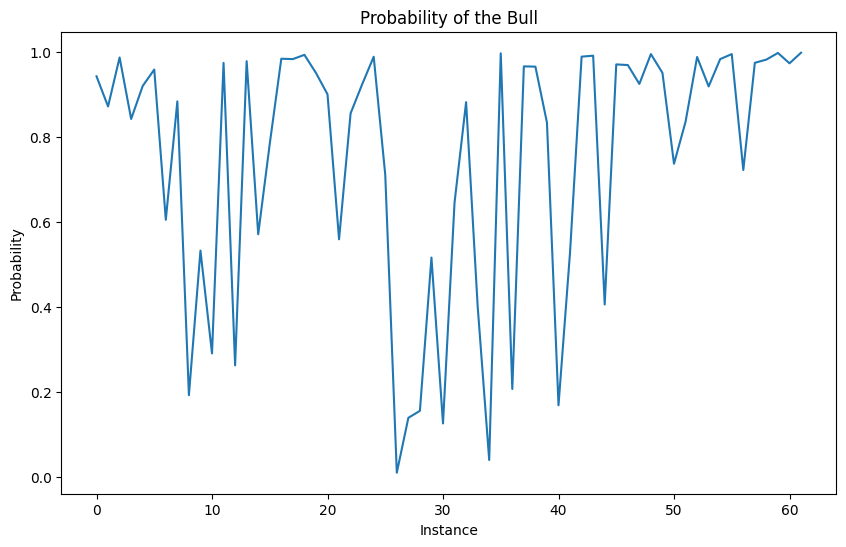

In [101]:
y_probabilities = model.predict_proba(X_test)
event_probability = y_probabilities[:, 1]
plt.figure(figsize=(10, 6))
plt.plot(event_probability)
plt.xlabel('Instance')
plt.ylabel('Probability')
plt.title('Probability of the Bull')
plt.show()

In [102]:
data.to_csv("Intermediate_data/branchmark_dataset.csv")